In [2]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import low_qual_chans, freq_bands_eeg

Change plot theme

In [3]:
sns.set_theme()

And define a palette to plot with

In [4]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}

Let the user select the needed folders

In [5]:
epoch_folder = select_folder("Select the folder that holds the social interaction experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-05-06 11:17:47.351 python[2309:75621] +[CATransaction synchronize] called within transaction
2024-05-06 11:17:53.668 python[2309:75621] +[CATransaction synchronize] called within transaction


In [6]:
epoch_folder

'/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/social_interaction/output/epochs'

In [7]:
plot_folder

'/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/social_interaction/output/plots'

Define the channels we're not interested in

In [8]:
excluded_chans = ['EMG_L', 'EMG_R']

Load all subject epochs

In [9]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif') or file.startswith('.'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [10]:
len(all_subject_epochs)

19

### Define some computation functions

In [11]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose="ERROR", gc_n_lags=40)
    return con.get_data(output='dense')

And a function that computes a dataframe holding the connectivity for all the subject's epochs.

In [12]:
def connectivity_df(subject_epoch_objects, method):
    results_df = pd.DataFrame()

    for subject_epochs in subject_epoch_objects:
                
        for event_type in subject_epochs.metadata['interaction_kind'].unique():
                
            interaction_kind_epochs = subject_epochs[subject_epochs.metadata['interaction_kind'] == event_type]
            if len(interaction_kind_epochs) == 0:
                continue
                
            interaction_kind_epochs = interaction_kind_epochs.drop_channels(excluded_chans)
            
            subject_id = int(interaction_kind_epochs.metadata['subject_id'].iloc[0])    
            genotype = interaction_kind_epochs.metadata['genotype'].iloc[0]
    
            # compute the given connectivity measure for every frequency band
            for band_name, (fmin, fmax) in freq_bands_eeg.items():
                
                # compute the connectivity using the provided method
                con = compute_con(interaction_kind_epochs, method, fmin, fmax)
                
                # loop through every channel combination
                for i in range(con.shape[1]):
                    for j in range(i+1, con.shape[0]):
                        if subject_id in low_qual_chans.keys():
                            if interaction_kind_epochs.ch_names[i] in low_qual_chans[subject_id] or interaction_kind_epochs.ch_names[j] in low_qual_chans[subject_id]:
                                continue
                        # add the data
                        results_df = pd.concat([results_df, pd.DataFrame({
                            'con' : con[j, i, 0],
                            'node1' : interaction_kind_epochs.ch_names[i],
                            'node2' : interaction_kind_epochs.ch_names[j],
                            'band' : band_name,
                            'subject_id': subject_id,
                            'genotype': genotype,
                            'event_type': event_type,
                        }, index=[0])], ignore_index=True)
                                
    return results_df

And also a function that allows us to generate a heatmap of the connectivity per channel combination

In [13]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

In [14]:
def generate_grid_plot_wt_vs_ko(data, event_type, method, cmap='flare'):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    freq_band_names = freq_bands_eeg.keys()
    genotypes = data['genotype'].unique()
    
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"connectivity/heatmaps/wt_vs_ko_{event_type}_{method}.pdf"))

Lastly a function that allows us to generate barplots of the connectivity measures

In [15]:
def generate_barplots(data, event_type, method):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True, sharex=True)
    axs = axs.ravel()
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/barplots/grid_{event_type}_{method}.pdf"))

## Exploration on a single subject (30958)

### Phase Lag Index exploration

#### Directed Phase-Lag-Index (dPLI)

In [15]:
for obj in all_subject_epochs:
    if obj.metadata.subject_id.iloc[0] == '39508':
        epochs_39508 = obj.copy()
        
epochs_39508.drop_channels(['S1_L', 'S1_R', 'V1_R', 'EMG_L', 'EMG_R'])
epochs_39508.info['ch_names']

['OFC_R', 'OFC_L', 'CG', 'STR_R']

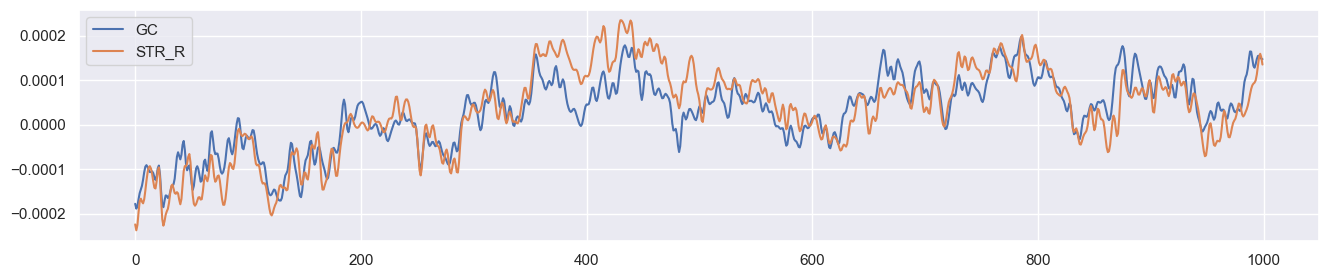

In [17]:
fig = plt.figure(figsize=(16, 3))
plt.plot(epochs_39508[5].get_data(picks='CG')[0,0,:], label='GC')
plt.plot(epochs_39508[5].get_data(picks='STR_R')[0,0,:], label='STR_R')
plt.legend()

Visually, the STR_R seems to lag behind the GC, or the GC leads the STR_R

In [19]:
seeds = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
targets = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
indices = seed_target_indices(seeds, targets)
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
dpli_test = spectral_connectivity_epochs(
    epochs_39508[5], indices=indices, sfreq=epochs_39508.info['sfreq'], method="dpli", fmin=5, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {dpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(dpli_test.freqs)}')
print(f'\nThe dPLI output:\n {dpli_test.get_data(output="dense")}')

Bi-variate indexes used for pairwise connectivity calculations:
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))

Shape of the dpli output: (4, 4, 96)

Length of the frequency array (holds at which the dPLI is calculated): 96

The dPLI output:
 [[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.  0.  0.  ... 1.  1.  1. ]
  [0.  0.  0.  ... 1.  1.  1. ]
  [1.  1.  1.  ... 1.  1.  1. ]]

 [[1.  1.  1.  ... 0.  0.  0. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.  1.  0.  ... 0.  0.  0. ]
  [1.  1.  1.  ... 0.  1.  0. ]]

 [[1.  1.  1.  ... 0.  0.  0. ]
  [1.  0.  1.  ... 1.  1.  1. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [1.  1.  1.  ... 0.  0.  0. ]]

 [[0.  0.  0.  ... 0.  0.  0. ]
  [0.  0.  0.  ... 1.  0.  1. ]
  [0.  0.  0.  ... 1.  1.  1. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]]


In [20]:
print(f'Mean dPLI for CG --> STR_R:  {np.average(dpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean dPLI for STR_R --> CG:  {np.average(dpli_test.get_data(output="dense")[3,2,:])}')

Mean dPLI for CG --> STR_R:  0.7604166666666666
Mean dPLI for STR_R --> CG:  0.23958333333333334


We can, from these, observe that they are each others opposites, which makes sense, as we calculate the **directed** phase-lag index here. If one leads or lags the other, the score of the reverse is gonna be the opposite. Note; the dPLI ranges from 0 to 1.

Now, how do we interpret this?

The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

So, the CG is leading the STR_R signal, or, the STR_R is lagging the CG signal.

#### Weighted Phase-Lag-Index (wPLI)

In [21]:
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
wpli_test = spectral_connectivity_epochs(
    epochs_39508[5], indices=indices, sfreq=epochs_39508.info['sfreq'], method="wpli", fmin=5, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {wpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(wpli_test.freqs)}')
print(f'\nThe dPLI output:\n {wpli_test.get_data(output="dense")}')

Bi-variate indexes used for pairwise connectivity calculations:
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))

Shape of the dpli output: (4, 4, 96)

Length of the frequency array (holds at which the dPLI is calculated): 96

The dPLI output:
 [[[0. 0. 0. ... 0. 0. 0.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [22]:
wpli_test.get_data(output="dense")[2,3,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [23]:
print(f'Mean wPLI for CG --> STR_R:  {np.average(wpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean wPLI for STR_R --> CG:  {np.average(wpli_test.get_data(output="dense")[3,2,:])}')

Mean wPLI for CG --> STR_R:  1.0
Mean wPLI for STR_R --> CG:  1.0


The wPLI ranges from 0 to 1, where 0 means no phase synchronization, and 1.0 means perfect phase synchronization, which refers to a situation where two signals exhibit a constant and consistent phase relationship across time. In this specific epoch, that wPLI tells us that that is the case.

## Connectivity for social versus non-social cup interaction epochs

### Coherence (coh)

In [42]:
conn = connectivity_df(all_subject_epochs, "coh")

In [44]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'coh')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'coh')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'coh')

In [30]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'coh')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'coh')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'coh')

### Imaginary coherence (imcoh)

In [45]:
conn = connectivity_df(all_subject_epochs, "imcoh")

In [46]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'imcoh')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'imcoh')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'imcoh')

In [47]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'imcoh')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'imcoh')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'imcoh')

### Corrected imaginary Phase Locking Value (ciPLV)

In [48]:
conn = connectivity_df(all_subject_epochs, "ciplv")

In [49]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'ciplv')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'ciplv')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'ciplv')

In [50]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'ciplv')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'ciplv')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'ciplv')

### Directed Phase Lag Index (dPLI)

In [51]:
conn = connectivity_df(all_subject_epochs, "dpli")

In [52]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'dpli')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'dpli')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'dpli')

In [53]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'dpli')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'dpli')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'dpli')

### Weighted Phase Lag Index (wPLI)

In [54]:
conn = connectivity_df(all_subject_epochs, "wpli")

In [55]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'wpli')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'wpli')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'wpli')

In [56]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'wpli')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'wpli')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'wpli')

### Debiased estimator of squared WPLI (wPLI-2 debiased)

In [57]:
conn = connectivity_df(all_subject_epochs, "wpli2_debiased")

In [58]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'wpli2_debiased')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'wpli2_debiased')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'wpli2_debiased')

In [59]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'wpli2_debiased')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'wpli2_debiased')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'wpli2_debiased')

### Pairwise Phase Consistency (PPC)

In [60]:
conn = connectivity_df(all_subject_epochs, "ppc")

/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/mne_connectivity/spectral/epochs_bivariate.py:343: RuntimeWarning: divide by zero encountered in divide
  con = (self._acc[con_idx] * np.conj(self._acc[con_idx]) - n_epochs) / (
/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/mne_connectivity/spectral/epochs_bivariate.py:343: RuntimeWarning: invalid value encountered in divide
  con = (self._acc[con_idx] * np.conj(self._acc[con_idx]) - n_epochs) / (
/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2/venv/lib/python3.9/site-packages/mne_connectivity/spectral/epochs_bivariate.py:343: RuntimeWarning: divide by zero encountered in divide
  con = (self._acc[con_

In [61]:
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'sniff'], 'sniff', 'ppc')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'follow'], 'follow', 'ppc')
generate_grid_plot_wt_vs_ko(conn[conn.event_type == 'groom'], 'groom', 'ppc')

In [62]:
generate_barplots(conn[conn.event_type == 'sniff'], 'sniff', 'ppc')
generate_barplots(conn[conn.event_type == 'follow'], 'follow', 'ppc')
generate_barplots(conn[conn.event_type == 'groom'], 'groom', 'ppc')

## Multivariate connectivity analysis

Compute the multivariate connectivity measures for all subject's epochs

#### First, we use all EEG channels

Now, we also include the skull electrodes, and of course still exclude the EMGs

In [16]:
results_df = pd.DataFrame()

# for each subject, get the resting/active/sleep epochs, drop the emg channels and calculate the mic and mim
for subj_epochs in all_subject_epochs:
    subject_id = int(subj_epochs.metadata['subject_id'].iloc[0])
    genotype = subj_epochs.metadata['genotype'].iloc[0]
    
    for behaviour in subj_epochs.metadata['interaction_kind'].unique():
        state_epochs = subj_epochs[subj_epochs.metadata['interaction_kind'] == behaviour]

        (mic, mim) = spectral_connectivity_epochs(state_epochs, method=['mic', 'mim'], n_jobs=-1, fmin=1, fmax=100, verbose='ERROR')
    
        results_df = pd.concat([results_df, pd.DataFrame({
            'animal_id' : subject_id,
            'genotype' : genotype,
            'behaviour': behaviour,
            'freqs' : mic.freqs,
            'mic' : mic.get_data()[0,:],
            'mim' : mim.get_data()[0,:],
            'low_qual_chans': True if subject_id in low_qual_chans.keys() else False
        })])

In [23]:
results_df_wo_low_qual_chans = results_df[results_df.low_qual_chans == False]

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df_wo_low_qual_chans.behaviour.unique()):
    results = results_df_wo_low_qual_chans.loc[results_df_wo_low_qual_chans['behaviour'] == interaction_kind]
    
    sns.lineplot(x=results.freqs, y=np.abs(results.mic), hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='lower right', frameon=False)
    
fig.suptitle("Maximised imaginary part of coherency (MIC) for the three events", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mic.pdf"))

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df_wo_low_qual_chans.behaviour.unique()):
    results = results_df_wo_low_qual_chans.loc[results_df_wo_low_qual_chans['behaviour'] == interaction_kind]
    
    sns.lineplot(x=results.freqs, y=results.mim, hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='lower right', frameon=False)
    
fig.suptitle("Multivariate interaction measure (MIM) for the three events", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mim.pdf"))